<a href="https://githubtocolab.com/BorjaRequena/Neural-Network-Course/blob/master/nbs/course/applications-cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

::: {.callout-note}

In this notebook we make extensive use of transfer learning, a technique that we will explain in a couple of lessons.

Furthermore, we use the [fastai](https://docs.fast.ai/) [@fastai] library to download the data for the different tasks and easily train our models.

::: 

In [ ]:
#| hide
# Uncomment and run this cell if using collab
# !pip install -U fastai
# !pip install -U scipy

In [ ]:
#| hide
from fastai.vision.all import *

# Introduction

Computer vision is the field of machine learning that deals with images in any form, be it medical images, our dog's cutest picture, some grayscale retro portrait or 8k videos. Processing these images, we can perform all sorts of tasks from identifying components within them to creating entirely new ones.   

Computer vision constitutes one of the most successful fields of machine learning. While in other fields, such as natural language processing, the progress has been slower, machines have long shown super-human results in the field of computer vision. For instance, a [remarkable work](https://www.nature.com/articles/s41551-018-0195-0) [@Poplin2018NatBiomedEng] (among so many others!) shows how we can detect a person’s age, gender, smoking status and systolic blood pressure, as well as inferring several risk factors directly from retinal images. At that time, we did not know inferring such information was even possible!

Here, we provide some basic examples of computer vision tasks. The goal is to obtain an idea of the typical kind of problems we can tackle and think about how **you** can use these to solve your problems. Currently, the most common practice in machine learning is to take a generic pre-trained model and adapt it to our specific task. This is known as transfer learning and we will make extensive usage of this technique to quickly solve the presented tasks. We will see transfer learning in a couple of lectures.

# Image classification

The most prototypical computer vision task is image classification. We do not rest easy if our machine learning courses and presentations do not display a cat and a dog image.

In image classification, we assign labels (among a finite pool) to images. Here, we illustrate the process with a rather funny example in which we aim to classify pet images into their respective breeds. The [dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) contains images of cats and dogs belonging to 37 different breeds. Let's have a look at some samples to get a better understanding of the task at hand.

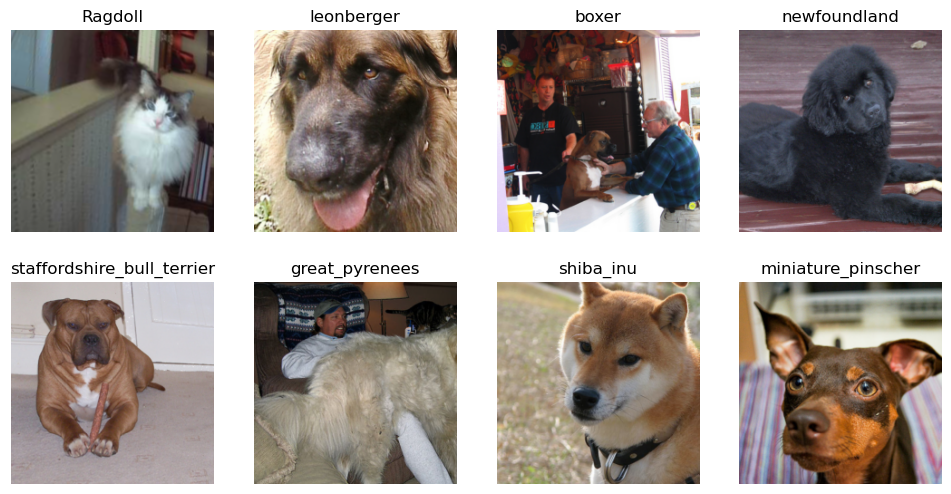

In [ ]:
#| code-fold: true
path = untar_data(URLs.PETS)

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files, 
                 splitter = RandomSplitter(seed=42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")
dls.show_batch(nrows=2, ncols=4)

We have images of dogs and cats that, in general, appear as the main body of the image. In some cases, we also encounter other objects that take up significant image space, such as humans or furniture. Our job will be to tell the breed to which the animal belongs to. As mentioned in the introduction, instead of training a whole model from scratch, we will take a pre-trained model and adapt it to classify these cats and dogs.

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

In this case, we will use a `resnet34` architecture trained on the [Imagnet dataset](http://www.image-net.org/). To get an idea, ImageNet has +20k classes to distinguish with, including several dog breeds. Given that the original task has a relationship with our current one, we can leverage this prior experience to classify our 37 pet breeds. 

Nonetheless, this pre-trained model was not build for our task, so we need to adapt it in order to output the pet breed prediction. To do so, we change the last trained layer by a fully connected layer with 37 outputs. At the beginning of the training, the main body of the model is already trained to extract features from images. However, the last bit that we append contains random weights. Therefore, it is convenient to, first, train the last bit for a few epochs before training the whole model at once.

What we will do is to *freeze* the model up to the last, recently appended layer. This way, there are no updates in the pre-trained part and the new part is adapted to work with it. Then, we *unfreeze* the model, allowing the whole thing to keep learning. Nevertheless, without getting into much detail, it is reasonable to think that the first layers of the model require less training that the final ones, provided that they focus on more generic aspects of the image, [such as edges or color gradients](https://arxiv.org/pdf/1311.2901.pdf). Therefore, we will set the learning rate of the initial layers to be lower than the last layers.

Thus, the main idea is:
- Freeze and train last bit at a high learning rate
- Unfreeze and train everything together with lower discriminative learning rates

Fastai has a built in functionality `learn.fine_tune` that handles the freezing/unfreezing for us, which is what we will be using for the rest of the notebook, after this example.

:::

Let's train the model!

In [ ]:
#| code-fold: true
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.freeze()
learn.fit_one_cycle(3, lr_max=1e-3, pct_start=0.99)
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(5e-6, 5e-4)) # Train first layers 100 times slower than last ones

epoch,train_loss,valid_loss,error_rate,time
0,3.621868,1.109150,0.296346,00:11
1,1.263898,0.269706,0.082544,00:11
2,0.606038,0.235287,0.078484,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.372174,0.201209,0.068336,00:13
1,0.334736,0.245479,0.078484,00:13
2,0.273055,0.197853,0.062923,00:13
3,0.178965,0.169431,0.054804,00:13
4,0.148987,0.167509,0.058187,00:13
5,0.112826,0.166959,0.056834,00:14


With transfer learning, in less than three minutes of training, we can classify pets into 37 breeds with an error rate of about ~5%. Let's have a look at some of the images in the validation set with the model predictions.

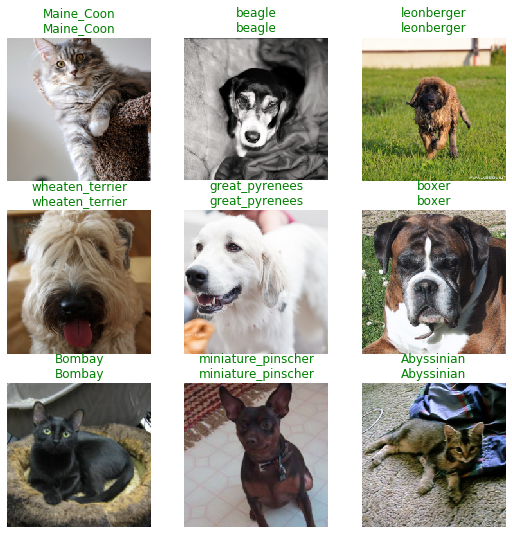

In [ ]:
#| code-fold: true
learn.show_results()

All the examples are properly classified. In order to better grasp the limitations of the model, we can check the confusion matrix, which will tell us what are the hardest breeds to classify for the model. In the confusion matrix, every row represents the actual label of the image, while the columns indicate the prediction of the model. Thus, a perfect classifier would have a diagonal confusion matrix. 

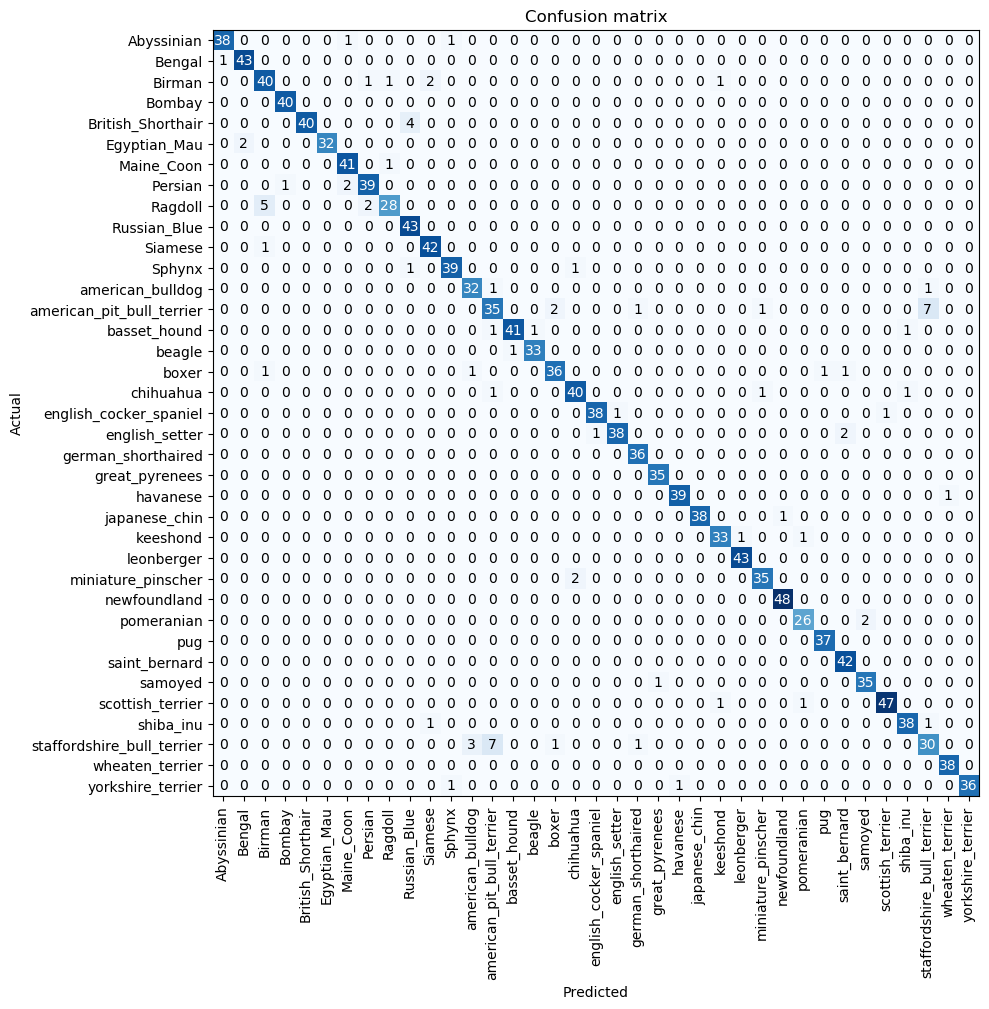

In [ ]:
#| code-fold: true
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=100)

The main error comes from the model mixing up some [American pit bull terriers](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) with [Staffordshire bull terriers](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier). There also seems to be some confusion between [ragdolls](https://en.wikipedia.org/wiki/Ragdoll) and [birmans](https://en.wikipedia.org/wiki/Birman). A quick google search reveals that we would probably do worse, so we can forgive the model for this mistake :)

## Multi-label classification

Within image classificaiton we, sometimes, encounter applications in which, rather than assigning a single label to each image, we need to provide a list of labels. This is known as multi-label classification and it is typically applied in situations in which we need to enumerate certain categories that appear in the image. 

I find it pretty intuitive to understand this kind of tasks with the analogy of a kid to whom we ask "what do you see in this image?" and the kid enumerates every single thing it can recognize in it: a tree, a dog, the sun, a lake, grass, a house, etc. Nonetheless, it will not be able to tell us things that it does know yet, such as the brand name of the car, or the name of a constellation in a night sky. In this case, the machine will be our kid and we will tell it exactly which things to identify in the images. 

To provide an example, we use the [PASCAL](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. Let's see how it looks like.

In [ ]:
#| code-fold: true
path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


We have a list of images with assigned labels and an indicator telling whether the image belongs to the validation set or not. See that the third image has a label 'horse person'. It is not a centaur, it's just two labels: horse and person. Let's have a look at the image.

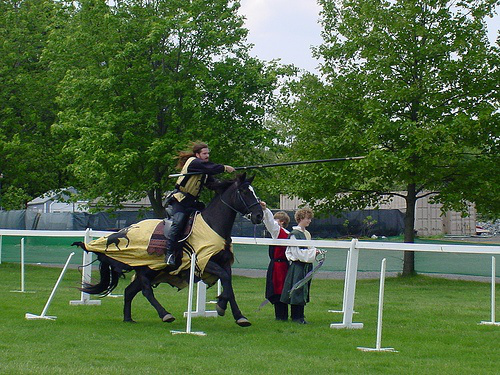

In [ ]:
#| code-fold: true
f = df.iloc[2, 0]
img = Image.open(path/"train"/f)
img

Indeed, there is a horse and three people. Notice that the task does not involve recognizing how many elements of a certain category are there. It is quite close to ticking a checkbox list of categories. In this dataset there are 20 categories:

In [ ]:
#| code-fold: true
labels = set()
for L in df.labels.unique(): labels.update(L.split(' '))
print(labels)

{'chair', 'cow', 'aeroplane', 'cat', 'pottedplant', 'person', 'bus', 'diningtable', 'sheep', 'tvmonitor', 'sofa', 'train', 'bird', 'horse', 'dog', 'bottle', 'boat', 'bicycle', 'motorbike', 'car'}


Hence, among those, the associated categories to the image are 'horse' and 'person'. Let us have a look at some more examples to get an idea of the kind of images that we encounter. 

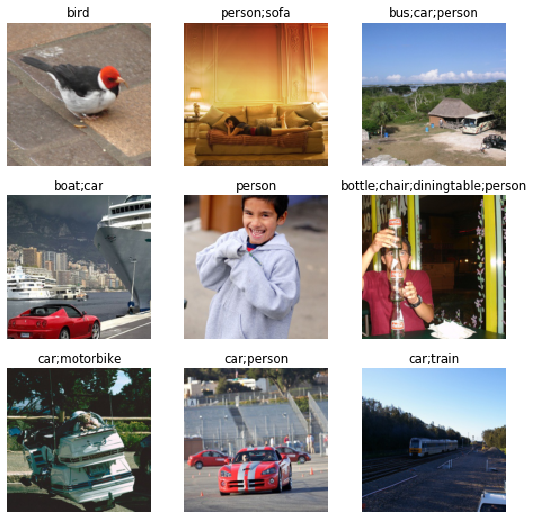

In [ ]:
#| code-fold: true
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

dls.show_batch()

Unlike in the previous task, where all images had either dogs or pets as main body, in this case, we encounter a wide range of different images going from close portraits to general landscape views with many different objects in them. Nonetheless, we will do the same as in the previous example: take a pre-trained model and adapt it to this specific task. 

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

In this case, we take a `resnet50`, which is larger than the previous `resnet34`. The architecture is also pre-trained in the [Imagenet dataset](http://www.image-net.org/) and we fine tune it for this multi-label classification. The output layer now contains 20 neurons indicating whether each category appears in the sample.

:::

Let's train!

In [ ]:
#| code-fold: true
learn = vision_learner(dls, resnet50, metrics=[accuracy_multi])
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.940069,0.709672,0.613805,00:06
1,0.820035,0.558362,0.734721,00:06
2,0.598636,0.201305,0.949064,00:06
3,0.356319,0.124212,0.957171,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135804,0.114497,0.959801,00:07
1,0.117852,0.107067,0.962769,00:07
2,0.097339,0.101569,0.964263,00:07


In less than a minute of training, we are capable of providing all the categories appearing in the given images with an accuracy of ~96%! Let's have a look at some examples in the validation set.

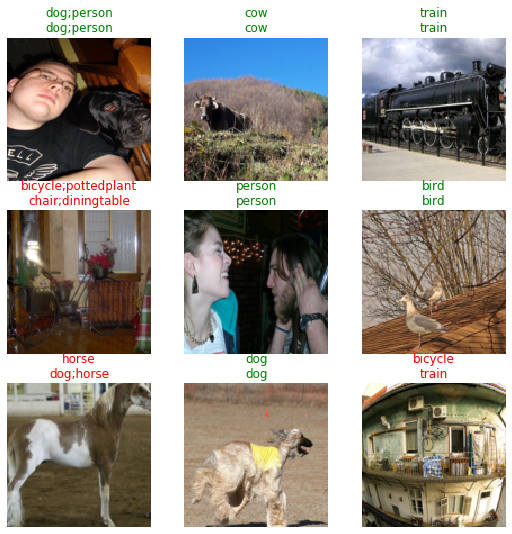

In [ ]:
#| code-fold: true
learn.show_results()

The model has been quite confused by the fourth image in which it had to predict bicycle and pottedplant and, instead, it predicted chair and diningtable. This was a tricky one. Nonetheless, the model has failed in much simpler ones, e.g., in the hrose image, it has predicted two categories: horse and dog, and, in the last one, it has predicted it to be a train, while it had to say bicycle. Despite the confusion, we can visualize the model failures and understand, for instance, how it confused the last image with a train. Hence, we can see that it works consistently with some room for improvement. 

## Image segmentation

In the image classification tasks that we have tackled so far, we have related classes with whole images, e.g., telling which pet breed appears in an image, or whether it contains any of a bunch of categories like horse and a person. We can go a step further and *assign a label to each pixel* to identify certain parts of the image. This is known as image segmentation.

This technique has numerious applications across very distinct fields. For instance, in autonomous driving we have to tell which parts of the image are road, traffic signs, pedestrians, etc. On a completely different approach, in biomedical imaging, segmentation is used to tell appart healthy tissue from regions affected by certain diseases, such as identifying tumorous cells among healthy ones. 

Here we will show a segmentation example using a subset of the [CamVid dataset](http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf) for autonomous driving. Let us have a look at some examples to get a better understanding of the task at hand. 

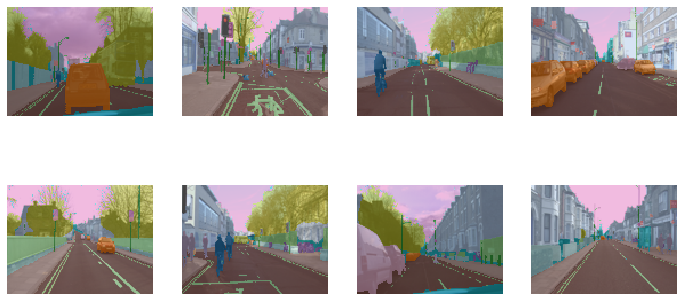

In [ ]:
#| code-fold: true
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str))

dls.show_batch()

Each pixel in the images is assigned a label indicating whether it is a tree, a traffic sign, a car, a bike, a building, a pedestrian, etc. Here, we see the images overlapped with the color-coded label mask to ease the visualization. The goal is, given an image, generate the color-coding mask, that is, another image. Again, we will leverage a pre-trained model to perform this task.  

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

Just as in the previous cases, we take the same pre-trained `resnet34` and adapt it for our task. In this case, we not only limit ourselves to change the last layer of the network but, also, we also modify its architecture. We use the weights from the pre-trained network and convert it into a [U-Net](https://arxiv.org/pdf/1505.04597.pdf) [@Ronneberger2015unet].

:::

Let's train!

In [ ]:
#| code-fold: true
learn = unet_learner(dls, resnet34)
learn.fine_tune(13)

epoch,train_loss,valid_loss,time
0,3.528453,2.278538,00:02


epoch,train_loss,valid_loss,time
0,1.917065,1.561294,00:02
1,1.638206,1.185067,00:02
2,1.489484,1.176791,00:02
3,1.446579,1.413508,00:02
4,1.363572,1.037536,00:02
5,1.251376,0.994358,00:02
6,1.151080,0.793147,00:02
7,1.053900,0.740798,00:02
8,0.969674,0.706727,00:02
9,0.896650,0.705011,00:02


Given that the dataset is rather small, the training is ridiculously fast. Here, we do not have a metric, such as error rate, that allows us to get an idea of the overall performance. Therefore, we will ask the model to generate the classification mask for some images and see how it goes in a rather qualitative way.

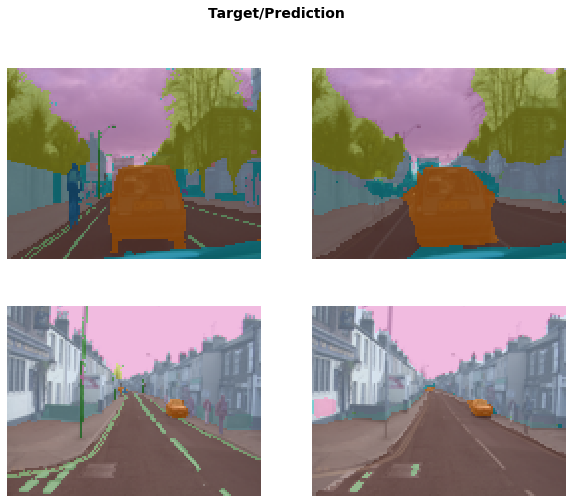

In [ ]:
#| code-fold: true
learn.show_results(max_n=4, figsize=(10, 8))

On the left, we see the real color-coding and, on the right, the model prediction. We can see that all the buildings, trees, cars and traffic signs are consistently colored, so the model is doing a great work here. The most difficult part seems to be the identification of road lines as well as accurately defining the shapes. The model has room for improvement and it would certainly perform better with a larger training dataset.

Beware, though, the model has entirely missed a cyclist in the first image, WATCH OUT!!

# Image regression

Another big family of applications is image regression tasks. A regression task is characterized by assigning a real number to a sample. Hence, rather than relating labels to the images, the model will have to provide a continuous value. We encounter this kind of tasks in various different fields, for instance, we can infer the temperature of the soil or other atmospherical properties from satelite images or identify the position of certain objects within them. 

To provide an example, we will use the [Biwi kinect head pose dataset](https://icu.ee.ethz.ch/research/datsets.html). The dataset is composed of frames from videos of people in which, in each frame, we have the coordinates of their head center. Let us have a look at a few examples to get a better picture of the task.

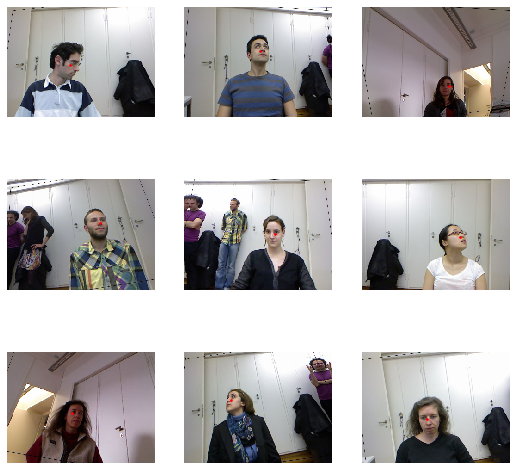

In [ ]:
#| code-fold: true
path = untar_data(URLs.BIWI_HEAD_POSE)

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)), 
                             Normalize.from_stats(*imagenet_stats)])
dls = biwi.dataloaders(path)
dls.show_batch()

Every image is provided with the 2D relative coordinates of the center of the head with respect to the center of the image, which is represented as a red dot. Hence, every image is assigned two continuous values (2D coordinates) between -1 and +1.   

Let's have a look at the target prediction of a five samples.

In [ ]:
#| code-fold: true
xb, yb = dls.one_batch()
print(yb[:5])

TensorPoint([[[-0.1538,  0.2342]],

        [[ 0.4655,  0.0642]],

        [[-0.0802, -0.1196]],

        [[ 0.0862, -0.1651]],

        [[-0.1449,  0.0769]]], device='cuda:0')


As in the previous applications, we leverage transfer learning to quickly solve this task. 

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

Again, we take a pre-trained `resnet34`. In this case, provided that the output are two continuous values, there will be two neurons in the output layer. We will restrict the value of each neuron to be within the (-1, 1) range with a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) $S(x)$ activation function such that the output $O(x)=S(x)(\text{high}-\text{low})+\text{low}$. This way, we reduce the amount of things the model needs to learn and prevent it from doing tremenduous mistakes.

:::

Train hard!

In [ ]:
#| code-fold: true
learn = vision_learner(dls, resnet34, y_range=(-1, 1))
learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,time
0,0.046086,0.010338,00:42


epoch,train_loss,valid_loss,time
0,0.007814,0.002069,00:56
1,0.002781,0.000177,00:56
2,0.001354,0.000255,00:56


With four minutes of training we reach a mean squared error (`valid_loss`) of $\sim10^{-4}$, meaning that, on average, the error in the predicted position is of the order of $\sim10^{-2}$. Since we do not know how bad it is to fail in the second decimal, let's have a look at some examples in order to see whether it is qualitatively awful or it's something we can't even tell. 

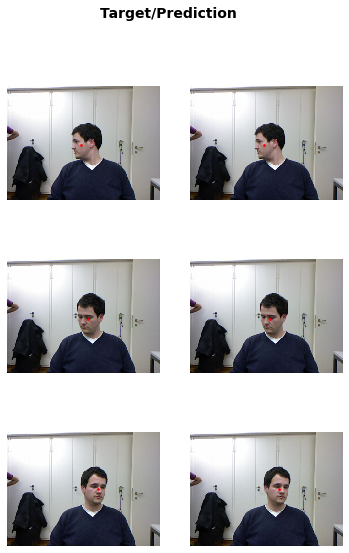

In [ ]:
#| code-fold: true
learn.show_results(nrows=3)

The model does great! Again, on the left, we have the real coordinates and, on the right, we have the prediction. The model error is barely noticeable so, even thogh we could probably refine the model to further lower it, this regressor is perfectly fine to be used within any related application. For instance, this could be used to detect the movement of a player in front of a camera in a virtual reality game.   

# Other computer vision applications

There is a myriad of different possible tasks in computer vision. Here, we just cover a few representative tasks which are, indeed, the foundation for more complex ones.

For example, the last image regression example can be turned into an object detection task to find people's heads. We can add a bounding box prediction around the dot and we're good to go! A classification task variant would be to assess whether two images belong to the same class, regardless of the class. Thus, in practice, this becomes a binary classification task and it is typically handled with [siamese neural networks](https://en.wikipedia.org/wiki/Siamese_neural_network).

Other prominent applications are generative tasks. These consist on generating new images and, by new, we mean that they did not exist ever before. This can either consist on modifying images, such as instagram and tiktok filters or [deepfakes](https://en.wikipedia.org/wiki/Deepfake), or generating them from scratch such as [these people](https://thispersondoesnotexist.com/) or [these cute cats](https://thiscatdoesnotexist.com/). We dive deeper into generative tasks in the next notebook about natural language processing.